### 1. Load the required libraries

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import time
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras import applications
from datetime import datetime as dt
from keras import regularizers as reg
from keras.optimizers import RMSprop
from keras.utils import to_categorical
import warnings
warnings.filterwarnings("ignore")
from keras.callbacks import ModelCheckpoint
from sklearn.externals import joblib
import os

Using TensorFlow backend.


## Utility functions

In [2]:
#This function is used to plot the train and test loss after each epoch.
import matplotlib.pyplot as plt
def plt_loss(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [3]:
#Dimensions of our flicker images is 256 X 256
img_width, img_height = 256, 256

#Declaration of parameters needed for training and validation
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
epochs = 50
batch_size = 20

In [4]:
datagen = ImageDataGenerator(rescale=1./255)

generator_tr = datagen.flow_from_directory(train_data_dir,
                                        target_size=(img_width, img_height),
                                        batch_size=batch_size,
                                        class_mode=None, #class_mode=None means the generator won't load the class labels.
                                        shuffle=False) #We won't shuffle the data, because we want the class labels to stay in order.

generator_ts = datagen.flow_from_directory(validation_data_dir,
                                        target_size=(img_width, img_height),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)

nb_train_samples = len(generator_tr.filenames) #10000. 2000 training samples for each class  
nb_validation_samples = len(generator_ts.filenames) #2500. 500 training samples for each class
num_classes = len(generator_tr.class_indices)

Found 10000 images belonging to 5 classes.
Found 2500 images belonging to 5 classes.


In [ ]:
os.mkdir("cnn_codes") if not os.path.isdir("cnn_codes") else None

#Get the bottleneck features by  Weights.T * Xi
def get_bottleneck_features(model_name):
    
    start=dt.now()
    
    #Load the pre trained model from Keras, we will initialize only the convolution layers and ignore the top layers.
    if model_name = "VGG16":
        model = applications.VGG16(include_top=False, weights='imagenet')
    elif model_name = "InceptionV3":
        model = applications.InceptionV3(include_top=False, weights='imagenet')
    elif model_name = "ResNet50": 
        model = applications.ResNet50(include_top=False, weights='imagenet')
    elif model_name = "InceptionResNetV2": 
        model = applications.InceptionResNetV2(include_top=False, weights='imagenet')
    elif model_name = "DenseNet201": 
        model = applications.DenseNet201(include_top=False, weights='imagenet')

    bottleneck_features_train = model.predict_generator(generator_tr, nb_train_samples // batch_size)
    np.save('cnn_codes/{}_bottleneck_features_train.npy'.format(model_name),bottleneck_features_train) #bottleneck_features_train is a numpy array


    bottleneck_features_validation = model.predict_generator(generator_ts, nb_validation_samples // batch_size)
    np.save('cnn_codes/{}_bottleneck_features_validation.npy'.format(model_name),bottleneck_features_validation)
    print("Got the bottleneck features for {} model, in time: ".format(model_name),dt.now()-start)

## 2. VGG16 Architecture

### 2.1 Get the bottleneck features using a pretrained VGG16 on Imagenet dataset.

In [3]:
get_bottleneck_features("VGG16")

Found 10000 images belonging to 5 classes.
Found 2500 images belonging to 5 classes.
Got the bottleneck features in time:  1:58:36.778060


### 2.2 Train a model with the bottleneck features obtained using VGG16

In [6]:
#After we get the bottleneck features, we will build the top fully connected layers on top of the bottlneck features. Let's build the top layers.
def train_model_vgg16():
    global_start=dt.now()

    train_data = np.load('cnn_codes/VGG16_bottleneck_features_train.npy')
    validation_data = np.load('cnn_codes/VGG16_bottleneck_features_validation.npy')
    
    #train_labels = np.array([0] * (nb_train_samples // 3) + [1] * (nb_train_samples // 3) + [2] * (nb_train_samples // 3)) #Equivalent to: np.array([0]*1200 + [1]*1200 + [2]*1200)
    #validation_labels = np.array([0] * (nb_validation_samples // 3) + [1] * (nb_validation_samples // 3) + [2] * (nb_validation_samples // 3))
    train_labels=generator_tr.classes  
    validation_labels=generator_ts.classes
    
    train_labels = to_categorical(train_labels, num_classes=num_classes)  
    validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:])) #Ignore the first index. It contains ID

    model.add(Dense(256, activation='relu',kernel_initializer='he_normal',kernel_regularizer=reg.l1_l2(l1=0.001, l2=0.001))) #Best weight initializer for relu is he_normal
    model.add(BatchNormalization()) #Add a BatchNormalization layer to control internel covariance shift
    model.add(Dropout(rate=0.5)) #Using droput for regularization

    model.add(Dense(256, activation='relu',kernel_initializer='he_normal',kernel_regularizer=reg.l1_l2(l1=0.001, l2=0.001)))
    model.add(BatchNormalization()) #Add a BatchNormalization layer to control internel covariance shift
    model.add(Dropout(rate=0.5))

    model.add(Dense(num_classes, activation='softmax',kernel_initializer='glorot_uniform')) #Because we have 3 classes. Remember, softmax is to multi-class, what sigmoid (log reg) is to binary

    optim=RMSprop(lr=0.0001, epsilon=1e-8, decay=1e-6)
    model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['accuracy'])
    model.summary()
    
    #Save the weights for the best epoch accuracy
    checkpointer = ModelCheckpoint(filepath="weights/vgg16_bottleneck_feats_multi_weights.hdf5", monitor = 'val_acc',verbose=1, save_best_only=True)
    model.fit(x=train_data,
              y=train_labels,
              epochs=epochs,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpointer])    
    
    #Refit our model with the best weights we got using model checkpointer
    #This step is absolutely needed, or else we might save our final model with model weights different from those we got using model checkpointer
    model.load_weights('weights/vgg16_bottleneck_feats_multi_weights.hdf5')
    model.save('models/vgg16_botlnck_trained.h5')
    print("\nThe top layer trained in time: ",dt.now()-global_start)
    
    return model

model=train_model_vgg16()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               8388864   
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
__________

['models/vgg16_using_bottleneck_best.pkl']

### 2.3 Get model performance (VGG16)

In [7]:
train_data = np.load('cnn_codes/VGG16_bottleneck_features_train.npy')
validation_data = np.load('cnn_codes/VGG16_bottleneck_features_validation.npy')

train_labels = to_categorical(generator_tr.classes, num_classes=num_classes)  
validation_labels = to_categorical(generator_ts.classes, num_classes=num_classes)

#Plot the train and test loss vs number of epochs
score = model.evaluate(validation_data, validation_labels, verbose=0) 
print('Validation Loss:', score[0]) 
print('Validation Accuracy on Unseen Data:', score[1])

Validation Loss: 1.1316226387023927
Validation Accuracy on Unseen Data: 0.9896


### 2.4 Visualize the train and validation loss for VGG16 model

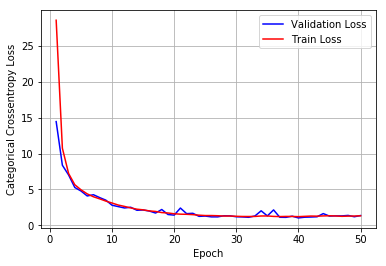

In [8]:
#Get model history
history=model.history

#Plot train vs test loss
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

#List of epoch numbers
x = list(range(1,epochs+1))

#Display the loss
val_loss = history.history['val_loss'] #Validation Loss
loss = history.history['loss'] #Training Loss
plt_loss(x, val_loss, loss, ax)

## 3. Inception V3

### 3.1 Get the bottleneck features using a pre-trained InceptionV3 on ImageNet dataset.

In [13]:
get_bottleneck_features("InceptionV3")

Found 10000 images belonging to 5 classes.
Found 2500 images belonging to 5 classes.
Got the bottleneck features in time:  0:35:39.074486


### 3.2 Train a model with the bottleneck features obtained using InceptionV3

In [6]:
#After we get the bottleneck features, we will build the top fully connected layers on top of the bottlneck features. Let's build the top layers.
def train_model_inceptionV3():
    global_start=dt.now()

    train_data = np.load('cnn_codes/InceptionV3_bottleneck_features_train.npy')
    validation_data = np.load('cnn_codes/InceptionV3_bottleneck_features_validation.npy')
    
    #train_labels = np.array([0] * (nb_train_samples // 3) + [1] * (nb_train_samples // 3) + [2] * (nb_train_samples // 3)) #Equivalent to: np.array([0]*1200 + [1]*1200 + [2]*1200)
    #validation_labels = np.array([0] * (nb_validation_samples // 3) + [1] * (nb_validation_samples // 3) + [2] * (nb_validation_samples // 3))
    train_labels=generator_tr.classes  
    validation_labels=generator_ts.classes
    
    train_labels = to_categorical(train_labels, num_classes=num_classes)  
    validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:])) #Ignore the first index. It contains ID

    model.add(Dense(256, activation='relu',kernel_initializer='he_normal',kernel_regularizer=reg.l1_l2(l1=0.001, l2=0.001))) #Best weight initializer for relu is he_normal
    model.add(BatchNormalization()) #Add a BatchNormalization layer to control internel covariance shift
    model.add(Dropout(rate=0.5)) #Using droput for regularization

    model.add(Dense(256, activation='relu',kernel_initializer='he_normal',kernel_regularizer=reg.l1_l2(l1=0.001, l2=0.001)))
    model.add(BatchNormalization()) #Add a BatchNormalization layer to control internel covariance shift
    model.add(Dropout(rate=0.5))

    model.add(Dense(num_classes, activation='softmax',kernel_initializer='glorot_uniform')) #Because we have 3 classes. Remember, softmax is to multi-class, what sigmoid (log reg) is to binary

    optim=RMSprop(lr=0.0001, epsilon=1e-8, decay=1e-6)
    model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['accuracy'])
    model.summary()
    
    #Save the weights for the best epoch accuracy
    checkpointer = ModelCheckpoint(filepath="weights/inceptionV3_bottleneck_feats_multi_weights.hdf5", monitor = 'val_acc',verbose=1, save_best_only=True)
                                   
    model.fit(x=train_data,
              y=train_labels,
              epochs=epochs,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpointer])    
    
    #Refit our model with the best weights saved before
    model.load_weights('weights/inceptionV3_bottleneck_feats_multi_weights.hdf5')
    model.save('models/inception_v3__botlnck_trained.h5')
    print("\nThe top layer trained in time: ",dt.now()-global_start)
    
    return model

model=train_model_inceptionV3()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               18874624  
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
__________

Epoch 35/50
10000/10000 [==============================] - 191s 19ms/step - loss: 1.7143 - acc: 0.9761 - val_loss: 1.7377 - val_acc: 0.9980

Epoch 00035: val_acc did not improve from 1.00000
Epoch 36/50
10000/10000 [==============================] - 192s 19ms/step - loss: 1.7278 - acc: 0.9756 - val_loss: 1.5218 - val_acc: 0.9956

Epoch 00036: val_acc did not improve from 1.00000
Epoch 37/50
10000/10000 [==============================] - 191s 19ms/step - loss: 1.7022 - acc: 0.9760 - val_loss: 1.6201 - val_acc: 0.9940

Epoch 00037: val_acc did not improve from 1.00000
Epoch 38/50
10000/10000 [==============================] - 200s 20ms/step - loss: 1.7148 - acc: 0.9750 - val_loss: 1.6147 - val_acc: 0.9856

Epoch 00038: val_acc did not improve from 1.00000
Epoch 39/50
10000/10000 [==============================] - 195s 20ms/step - loss: 1.6631 - acc: 0.9758 - val_loss: 1.5949 - val_acc: 0.9916

Epoch 00039: val_acc did not improve from 1.00000
Epoch 40/50
10000/10000 [====================

### 3.3 Get model performance (InceptionV3)

In [7]:
train_data = np.load('cnn_codes/InceptionV3_bottleneck_features_train.npy')
validation_data = np.load('cnn_codes/InceptionV3_bottleneck_features_validation.npy')

train_labels = to_categorical(generator_tr.classes, num_classes=num_classes)  
validation_labels = to_categorical(generator_ts.classes, num_classes=num_classes)

#Plot the train and test loss vs number of epochs
score = model.evaluate(validation_data, validation_labels, verbose=0) 
print('Validation Loss:', score[0]) 
print('Validation Accuracy on Unseen Data):', score[1])

Validation Loss: 1.6466785596847535
Validation Accuracy on Unseen Data): 1.0


### 3.4 Visualize the train and validation loss for InceptionV3 model

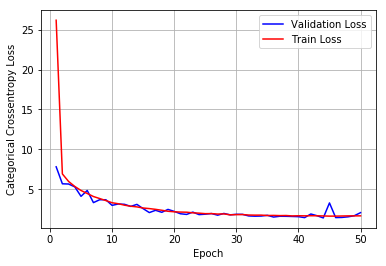

In [10]:
#Get model history
history=model.history

#Plot train vs test loss
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

#List of epoch numbers
x = list(range(1,epochs+1))

#Display the loss
val_loss = history.history['val_loss'] #Validation Loss
loss = history.history['loss'] #Training Loss
plt_loss(x, val_loss, loss, ax)

## 4. ResNet50

### 4.1 Get the bottleneck features using a pre-trained ResNet50 on Imagenet dataset.

In [5]:
get_bottleneck_features("ResNet50")

Found 10000 images belonging to 5 classes.
Found 2500 images belonging to 5 classes.
Got the bottleneck features in time:  0:51:25.690934


### 4.2 Train a model with the bottleneck features obtained using ResNet50

In [5]:
#After we get the bottleneck features, we will build the top fully connected layers on top of the bottlneck features. Let's build the top layers.
def train_model_resnet50():
    global_start=dt.now()

    train_data = np.load('cnn_codes/ResNet50_bottleneck_features_train.npy')
    validation_data = np.load('cnn_codes/ResNet50_bottleneck_features_validation.npy')
    
    #train_labels = np.array([0] * (nb_train_samples // 3) + [1] * (nb_train_samples // 3) + [2] * (nb_train_samples // 3)) #Equivalent to: np.array([0]*1200 + [1]*1200 + [2]*1200)
    #validation_labels = np.array([0] * (nb_validation_samples // 3) + [1] * (nb_validation_samples // 3) + [2] * (nb_validation_samples // 3))
    train_labels=generator_tr.classes  
    validation_labels=generator_ts.classes
    
    train_labels = to_categorical(train_labels, num_classes=num_classes)  
    validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:])) #Ignore the first index. It contains ID

    model.add(Dense(256, activation='relu',kernel_initializer='he_normal',kernel_regularizer=reg.l1_l2(l1=0.001, l2=0.001))) #Best weight initializer for relu is he_normal
    model.add(BatchNormalization()) #Add a BatchNormalization layer to control internel covariance shift
    model.add(Dropout(rate=0.5)) #Using droput for regularization

    model.add(Dense(256, activation='relu',kernel_initializer='he_normal',kernel_regularizer=reg.l1_l2(l1=0.001, l2=0.001)))
    model.add(BatchNormalization()) #Add a BatchNormalization layer to control internel covariance shift
    model.add(Dropout(rate=0.5))

    model.add(Dense(num_classes, activation='softmax',kernel_initializer='glorot_uniform')) #Because we have 3 classes. Remember, softmax is to multi-class, what sigmoid (log reg) is to binary

    optim=RMSprop(lr=0.0001, epsilon=1e-8, decay=1e-6)
    model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['accuracy'])
    model.summary()
    
    #Save the weights for the best epoch accuracy
    checkpointer = ModelCheckpoint(filepath="weights/resnet50_bottleneck_feats_multi_weights.hdf5", monitor = 'val_acc',verbose=1, save_best_only=True)
                                   
    model.fit(x=train_data,
              y=train_labels,
              epochs=50,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpointer])    
    
    #Refit our model with the best weights saved before
    model.load_weights('weights/resnet50_bottleneck_feats_multi_weights.hdf5')
    model.save('models/resnet50__botlnck_trained.h5')
    print("\nThe top layer trained in time: ",dt.now()-global_start)
    
    return model

model=train_model_resnet50()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33554688  
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_2


Epoch 00029: val_acc did not improve from 0.85080
Epoch 30/50
10000/10000 [==============================] - 324s 32ms/step - loss: 3.1222 - acc: 0.7002 - val_loss: 5.7723 - val_acc: 0.3244

Epoch 00030: val_acc did not improve from 0.85080
Epoch 31/50
10000/10000 [==============================] - 327s 33ms/step - loss: 3.0628 - acc: 0.7106 - val_loss: 3.3840 - val_acc: 0.5252

Epoch 00031: val_acc did not improve from 0.85080
Epoch 32/50
10000/10000 [==============================] - 333s 33ms/step - loss: 3.0388 - acc: 0.7076 - val_loss: 4.3927 - val_acc: 0.4840

Epoch 00032: val_acc did not improve from 0.85080
Epoch 33/50
10000/10000 [==============================] - 329s 33ms/step - loss: 3.0135 - acc: 0.7097 - val_loss: 3.1652 - val_acc: 0.6764

Epoch 00033: val_acc did not improve from 0.85080
Epoch 34/50
10000/10000 [==============================] - 327s 33ms/step - loss: 2.9674 - acc: 0.7187 - val_loss: 2.7190 - val_acc: 0.8320

Epoch 00034: val_acc did not improve from 0.

['models/resnet_using_bottleneck_best.pkl']

### 4.3 Get model performance (ResNet50)

In [57]:
train_data = np.load('cnn_codes/ResNet50_bottleneck_features_train.npy')
validation_data = np.load('cnn_codes/ResNet50_bottleneck_features_validation.npy')

train_labels = to_categorical(generator_tr.classes, num_classes=num_classes)  
validation_labels = to_categorical(generator_ts.classes, num_classes=num_classes)

#Plot the train and test loss vs number of epochs
score = model.evaluate(validation_data, validation_labels, verbose=0) 
print('Validation Loss:', score[0]) 
print('Validation Accuracy on Unseen Data):', score[1])

Test score (Validation Loss): 6.141017456054687
Test accuracy (Accuracy on Unseen Data): 0.965


### 4.4 Visualize the train and validation loss for ResNet50 model

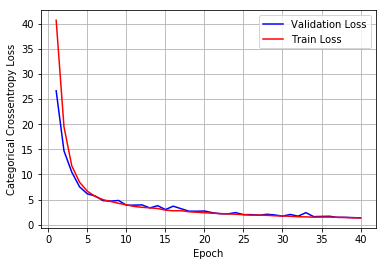

In [59]:
#Get model history
history=model.history

#Plot train vs test loss
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

#List of epoch numbers
x = list(range(1,epochs+1))

#Display the loss
val_loss = history.history['val_loss'] #Validation Loss
loss = history.history['loss'] #Training Loss
plt_dynamic_loss(x, val_loss, loss, ax)

## 5. DenseNet201

### 5.1 Get the bottleneck features using a pre-trained DenseNet201 on Imagenet dataset.

In [3]:
get_bottleneck_features("DenseNet201")

Found 10000 images belonging to 5 classes.
Found 2500 images belonging to 5 classes.
Got the bottleneck features in time:  1:17:11.040657


### 5.2 Train a model with the bottleneck features obtained using DenseNet201

In [5]:
#After we get the bottleneck features, we will build the top fully connected layers on top of the bottlneck features. Let's build the top layers.
def train_model_densenet201():
    global_start=dt.now()

    train_data = np.load('cnn_codes/DenseNet201_bottleneck_features_train.npy')
    validation_data = np.load('cnn_codes/DenseNet201_bottleneck_features_test.npy')
    
    #train_labels = np.array([0] * (nb_train_samples // 3) + [1] * (nb_train_samples // 3) + [2] * (nb_train_samples // 3)) #Equivalent to: np.array([0]*1200 + [1]*1200 + [2]*1200)
    #validation_labels = np.array([0] * (nb_validation_samples // 3) + [1] * (nb_validation_samples // 3) + [2] * (nb_validation_samples // 3))
    train_labels=generator_tr.classes  
    validation_labels=generator_ts.classes
    
    train_labels = to_categorical(train_labels, num_classes=num_classes)  
    validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:])) #Ignore the first index. It contains ID

    model.add(Dense(256, activation='relu',kernel_initializer='he_normal',kernel_regularizer=reg.l1_l2(l1=0.001, l2=0.001))) #Best weight initializer for relu is he_normal
    model.add(BatchNormalization()) #Add a BatchNormalization layer to control internel covariance shift
    model.add(Dropout(rate=0.5)) #Using droput for regularization

    model.add(Dense(256, activation='relu',kernel_initializer='he_normal',kernel_regularizer=reg.l1_l2(l1=0.001, l2=0.001)))
    model.add(BatchNormalization()) #Add a BatchNormalization layer to control internel covariance shift
    model.add(Dropout(rate=0.5))

    model.add(Dense(num_classes, activation='softmax',kernel_initializer='glorot_uniform')) #Because we have 3 classes. Remember, softmax is to multi-class, what sigmoid (log reg) is to binary

    optim=RMSprop(lr=0.0001, epsilon=1e-8, decay=1e-6)
    model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['accuracy'])
    model.summary()
    
    #Save the weights for the best epoch accuracy
    checkpointer = ModelCheckpoint(filepath="weights/densenet201_bottleneck_feats_multi_weights.hdf5", monitor = 'val_acc',verbose=1, save_best_only=True)
                                   
    model.fit(x=train_data,
              y=train_labels,
              epochs=epochs,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpointer])    
    
    #Refit our model with the best weights saved before
    model.load_weights('weights/densenet201_bottleneck_feats_multi_weights.hdf5')
    model.save('models/dense_net201_botlnck_trained.h5')
    print("\nThe top layer trained in time: ",dt.now()-global_start)
    
    return model

model=train_model_densenet201()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 122880)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               31457536  
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_2

10000/10000 [==============================] - 330s 33ms/step - loss: 2.3905 - acc: 0.9808 - val_loss: 2.8720 - val_acc: 0.9468

Epoch 00030: val_acc did not improve from 1.00000
Epoch 31/50
10000/10000 [==============================] - 335s 33ms/step - loss: 2.3659 - acc: 0.9812 - val_loss: 2.5566 - val_acc: 0.9864

Epoch 00031: val_acc did not improve from 1.00000
Epoch 32/50
10000/10000 [==============================] - 332s 33ms/step - loss: 2.3938 - acc: 0.9808 - val_loss: 3.4078 - val_acc: 0.7732

Epoch 00032: val_acc did not improve from 1.00000
Epoch 33/50
10000/10000 [==============================] - 332s 33ms/step - loss: 2.3148 - acc: 0.9825 - val_loss: 2.3835 - val_acc: 0.9984

Epoch 00033: val_acc did not improve from 1.00000
Epoch 34/50
10000/10000 [==============================] - 347s 35ms/step - loss: 2.3174 - acc: 0.9837 - val_loss: 2.3965 - val_acc: 0.9988

Epoch 00034: val_acc did not improve from 1.00000
Epoch 35/50
10000/10000 [==============================] 

['models/densenet201_using_bottleneck_best.pkl']

### 5.3 Get model performance (DenseNet201)

In [6]:
train_data = np.load('cnn_codes/DenseNet201_bottleneck_features_train.npy')
validation_data = np.load('cnn_codes/DenseNet201_bottleneck_features_test.npy')

train_labels = to_categorical(generator_tr.classes, num_classes=num_classes)  
validation_labels = to_categorical(generator_ts.classes, num_classes=num_classes)

#Plot the train and test loss vs number of epochs
score = model.evaluate(validation_data, validation_labels, verbose=0) 
print('Validation Loss:', score[0]) 
print('Validation Accuracy on Unseen Data):', score[1])

Validation Loss: 2.3363968044281007
Validation Accuracy on Unseen Data): 1.0


### 5.4 Visualize the train and validation loss for DenseNet201 model

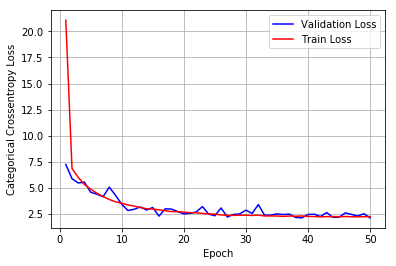

In [8]:
#Get model history
history=model.history

#Plot train vs test loss
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

#List of epoch numbers
x = list(range(1,epochs+1))

#Display the loss
val_loss = history.history['val_loss'] #Validation Loss
loss = history.history['loss'] #Training Loss
plt_loss(x, val_loss, loss, ax)

## 6. InceptionResNetV2

### 6.1 Get the bottleneck features using a pre-trained InceptionResNetV2 on Imagenet dataset.

In [4]:
get_bottleneck_features("InceptionResNetV2")

Found 10000 images belonging to 5 classes.
Found 2500 images belonging to 5 classes.
Got the bottleneck features in time:  1:05:57.233727


### 6.2 Train a model with the bottleneck features obtained using InceptionResNetV2

In [6]:
#After we get the bottleneck features, we will build the top fully connected layers on top of the bottlneck features. Let's build the top layers.
def train_model_InceptionResNetV2():
    global_start=dt.now()

    train_data = np.load('cnn_codes/InceptionResNetV2_bottleneck_features_train.npy')
    validation_data = np.load('cnn_codes/InceptionResNetV2_bottleneck_features_validation.npy')
    
    #train_labels = np.array([0] * (nb_train_samples // 3) + [1] * (nb_train_samples // 3) + [2] * (nb_train_samples // 3)) #Equivalent to: np.array([0]*1200 + [1]*1200 + [2]*1200)
    #validation_labels = np.array([0] * (nb_validation_samples // 3) + [1] * (nb_validation_samples // 3) + [2] * (nb_validation_samples // 3))
    train_labels=generator_tr.classes  
    validation_labels=generator_ts.classes
    
    train_labels = to_categorical(train_labels, num_classes=num_classes)  
    validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:])) #Ignore the first index. It contains ID

    model.add(Dense(256, activation='relu',kernel_initializer='he_normal',kernel_regularizer=reg.l1_l2(l1=0.001, l2=0.001))) #Best weight initializer for relu is he_normal
    model.add(BatchNormalization()) #Add a BatchNormalization layer to control internel covariance shift
    model.add(Dropout(rate=0.5)) #Using droput for regularization

    model.add(Dense(256, activation='relu',kernel_initializer='he_normal',kernel_regularizer=reg.l1_l2(l1=0.001, l2=0.001)))
    model.add(BatchNormalization()) #Add a BatchNormalization layer to control internel covariance shift
    model.add(Dropout(rate=0.5))

    model.add(Dense(num_classes, activation='softmax',kernel_initializer='glorot_uniform')) #Because we have 3 classes. Remember, softmax is to multi-class, what sigmoid (log reg) is to binary

    optim=RMSprop(lr=0.0001, epsilon=1e-8, decay=1e-6)
    model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['accuracy'])
    model.summary()
    
    #Save the weights for the best epoch accuracy
    checkpointer = ModelCheckpoint(filepath="weights/InceptionResNetV2_bottleneck_feats_multi_weights.hdf5", monitor = 'val_acc',verbose=1, save_best_only=True)
                                   
    model.fit(x=train_data,
              y=train_labels,
              epochs=epochs,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpointer])    
    
    #Refit our model with the best weights saved before
    model.load_weights('weights/InceptionResNetV2_bottleneck_feats_multi_weights.hdf5')
    model.save('models/incep_res_v2_botlnck_trained.h5')
    print("\nThe top layer trained in time: ",dt.now()-global_start)
    
    return model

model=train_model_InceptionResNetV2()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 55296)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               14156032  
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
__________

['models/InceptionResNetV2_using_bottleneck_best.pkl']

### 6.3 Get model performance (InceptionResNetV2)

In [7]:
train_data = np.load('cnn_codes/InceptionResNetV2_bottleneck_features_train.npy')
validation_data = np.load('cnn_codes/InceptionResNetV2_bottleneck_features_validation.npy')

train_labels = to_categorical(generator_tr.classes, num_classes=num_classes)  
validation_labels = to_categorical(generator_ts.classes, num_classes=num_classes)

#Plot the train and test loss vs number of epochs
score = model.evaluate(validation_data, validation_labels, verbose=0) 
print('Validation Loss:', score[0]) 
print('Validation Accuracy on Unseen Data):', score[1])

Validation Loss: 1.44897696723938
Validation Accuracy on Unseen Data): 1.0


### 5.4 Visualize the train and validation loss for InceptionResNetV2 model

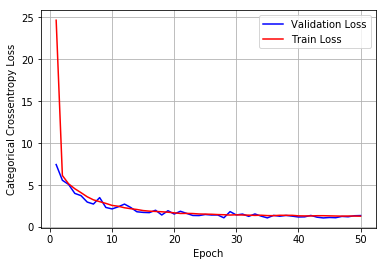

In [9]:
#Get model history
history=model.history

#Plot train vs test loss
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

#List of epoch numbers
x = list(range(1,epochs+1))

#Display the loss
val_loss = history.history['val_loss'] #Validation Loss
loss = history.history['loss'] #Training Loss
plt_loss(x, val_loss, loss, ax)

## Prediction function

In [15]:
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
from keras import applications
import time
import numpy as np

def load_image(file):
    test_image = load_img(file, target_size=(256,256))
    test_image = img_to_array(test_image)
    test_image = test_image / 255.0
    test_image = np.expand_dims(test_image, axis=0)
    return test_image

def load_model_trained():
    vgg = applications.VGG16(include_top=False, weights='imagenet',input_shape=(256,256,3))
    path='models/vgg16_bottleneck_feats_multi_weights.hdf5'
    model=load_model(path)
    return model, vgg

def predict_image(model,vgg,test_image):
    start = time.time()
    bottleneck_prediction=vgg.predict(test_image)
    result = model.predict_classes(bottleneck_prediction) 
        
    
    if result[0] == 0:
        print("It's a Dog!")
    elif result[0] == 1:
        print("It's a Frog!")
    elif result[0] == 2:
        print("It's a Giraffe!")
    elif result[0] == 3:
        print("It's a Horse!")
    elif result[0] == 4:
        print("It's a Tiger!")

    #Calculate execution time
    print("\nTest Time: ",np.round(time.time()-start,2),"seconds") 
    
model,vgg=load_model_trained()

In [24]:
filename="test/006.jpg"
test_image=load_image(filename)

predict_image(model,vgg,test_image)

It's a Tiger!

Test Time:  0.68 seconds


### Visualize all the layers in the neural network

In [ ]:
train_data = np.load('weights/bottleneck_features_train.npy')
model = applications.VGG16(include_top=False, weights='imagenet')
model.summary()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

def visualize_filters(layer, nrows, ncols):
    """Given a layer as an input, the function will plot all the filters present in that layer in x by y format.
    For example suppose our input layer is block1_conv1 and we have 32 feature maps. This function will display
    all the 32 feature maps in 8 X 4 view."""
    filters=layer.get_weights()
    fig=plt.figure(figsize=(50,25))
    for i in range(0,len(filters)):
        ax=fig.add_subplot(ncols,nrows,i+1)
        ax.matshow(filters[i][0][0], cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.tight_layout()
    return plt

visualize_filters(model.layers[1],4,16)

In [ ]:
layer=model.layers[1]
filters=layer.get_weights()
filters[0][0][0][0]

In [ ]:
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", 
                               monitor = 'val_acc',
                               verbose=1, 
                               save_best_only=True)

callbacks=[checkpointer] in fit_generator

"""The model will train for 30 epochs but we will use ModelCheckpoint to store the weights of the best performing epoch. 
We will specify val_acc as the metric to use to define the best model. This means we will keep the weights of the epoch that scores highest in terms of accuracy on the test set."""

In [ ]:
filters[0][3]
classifier.load_weights('best_weights.hdf5')